In [1]:
import sys
import numpy as np
import xarray as xr
import itertools as it
import os.path
import multiprocessing as mp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import tensorflow as tf
import sklearn
from keras.layers import *
from keras.regularizers import l1,l2
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error
from keras import backend as K
from livelossplot.keras import PlotLossesCallback
from dr_eval import trust_cont_score

CPU_COUNT = mp.cpu_count()
print('{} CPUs'.format(CPU_COUNT))
print('numpy version: {}'.format(np.__version__))
print('xarray version: {}'.format(xr.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('sklearn version: {}'.format(sklearn.__version__))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


8 CPUs
numpy version: 1.15.4
xarray version: 0.11.3
matplotlib version: 3.0.2
sklearn version: 0.20.1


In [2]:
use_data_caching = True
keep_original_data_loaded = False
experiment = 'rcp26'

model_names = xr.open_dataset('./data/{0}/{0}_m6_tas_pr.nc'.format(experiment)).coords['model']

X_all_filename = './data/X_{}_all.npy'.format(experiment)
X_train_filename = './data/X_{}_train.npy'.format(experiment)
X_valid_filename = './data/X_{}_valid.npy'.format(experiment)
ls_mask_filename = './data/lsmask_cmip3_144.nc'
if use_data_caching and os.path.isfile(X_all_filename):
    print('loading cached data file {}'.format(X_all_filename))
    X_all = np.load(X_all_filename)
else:
    print('loading and processing dataset for experiment {}'.format(experiment))
    X_ds = xr.open_dataset('./data/{0}/{0}_m6_tas_pr.nc'.format(experiment))
    X_arr = X_ds.to_array().transpose('model', 'time', 'lat', 'lon', 'variable')
    X_all = X_arr.values
    nan_count = np.product(X_all.shape) - np.count_nonzero(~np.isnan(X_all))
    print('found {} NaN values in data'.format(nan_count))
    assert nan_count == 0
    # standardize variables
    for i in range(X_all.shape[-1]):
        stddev = np.std(X_all[:,:,:,:,i])
        X_all[:,:,:,:,i] = X_all[:,:,:,:,i] / stddev
    if use_data_caching:
        np.save(X_all_filename, X_all)
    
N_models, N_time, N_lat, N_lon, N_vars = X_all.shape
BATCH_SIZE = N_models*N_time // 20
    
N_models_train = N_models - 2
N_models_valid = N_models - N_models_train
N_train = N_models_train*N_time
N_valid = N_models_valid*N_time

if os.path.isfile(ls_mask_filename):
    print('loading land/sea mask data file')
    X_ls_mask = xr.open_dataset(ls_mask_filename)
    X_sea_mask = 1 - X_ls_mask.to_array().values.reshape((1, N_lat, N_lon, 1))

if use_data_caching and os.path.isfile(X_train_filename):
    print('loading cached data file {}'.format(X_train_filename))
    X_train = np.load(X_train_filename)
else:
    print('generating training data')
    X_train = np.hstack(X_all[:N_models_train]).reshape((N_models_train*N_time, N_lat, N_lon, N_vars))
    if use_data_caching:
        np.save(X_train_filename, X_train)

if use_data_caching and os.path.isfile(X_valid_filename):
    print('loading cached data file {}'.format(X_valid_filename))
    X_valid = np.load(X_valid_filename)
else:
    print('generating validation data')
    X_valid = np.hstack(X_all[N_models_train:]).reshape((N_models_valid*N_time, N_lat, N_lon, N_vars))
    if use_data_caching:
        np.save(X_valid_filename, X_valid)

if not keep_original_data_loaded:
    del X_all
    
X_train_sea = X_train * X_sea_mask
X_valid_sea = X_valid * X_sea_mask

print('Loaded training data with shape: {}'.format(X_train.shape))
print('Loaded validation data with shape: {}'.format(X_valid.shape))

loading cached data file ./data/X_rcp26_all.npy
loading land/sea mask data file
loading cached data file ./data/X_rcp26_train.npy
loading cached data file ./data/X_rcp26_valid.npy
Loaded training data with shape: (11520, 72, 144, 2)
Loaded validation data with shape: (5760, 72, 144, 2)


In [3]:
from mpl_toolkits.basemap import Basemap

def plot_image_map(X, cmap="seismic", title="", min_max=None):
    basemap = Basemap(lat_0=0, lon_0=180)
    img = basemap.imshow(X, origin='lower', cmap=cmap)
    basemap.drawcoastlines()
    if min_max is not None:
        img.set_clim(vmin=min_max[0], vmax=min_max[1])
    plt.colorbar(fraction=0.035, pad=0.04)
    plt.title(title)

def plot_var_spatial(X, X_pred, name="model", cmap='brg', t=0, c=0):
    fig = plt.figure(figsize=(16,14))
    avg_x = np.mean(X)
    std_x = np.std(X)
    min_x = avg_x - 2*std_x
    max_x = avg_x + 2*std_x
    plt.subplot(1,2,1)
    plot_image_map(X[0,:,:,c], cmap=cmap, title='{}, t={}'.format(name, t))
    plt.clim(vmin=min_x, vmax=max_x)
    plt.subplot(1,2,2)
    plot_image_map(X_pred[0,:,:,c], cmap=cmap, title='{}, t={}, reconstructed'.format(name, t))
    plt.clim(vmin=min_x, vmax=max_x)
    plt.show()
    
def plot_err_spatial(X, X_pred, target_shape=(1, N_lat, N_lon, N_vars), cmap="Reds", name="", t=0,c=0):
    plt.figure(figsize=(7,6))
    X_err = np.abs(X - X_pred)[0,:,:,c]
    plot_image_map(X_err.reshape((N_lat, N_lon)), cmap=cmap, title='{}, total absolute error, t={}'.format(name, t))
    
def plot_var_time(X, X_pred, model_name="model", name="", c=0):
    plt.plot(range(X.shape[0]), np.mean(X, axis=(1,2))[:,c], c='blue')
    plt.title('{}, global average, original'.format(name))
    plt.plot(range(X_pred.shape[0]), np.mean(X_pred, axis=(1,2))[:,c], ':', c='red')
    plt.title('{}, global average, reconstructed'.format(name))
    plt.legend(['original', model_name])
    
def predict_batches(X, model):
    X_pred = np.zeros((0, *X.shape[1:]))
    batch_size = X.shape[0] // 10
    for i in range(10):
        X_next = model.predict_on_batch(X[i*batch_size:(i+1)*batch_size])
        X_pred = np.concatenate([X_pred, X_next], axis=0)
    return X_pred
    
def show_activations(X, model, layer, output_shape, t=0, name=""):
    inputs = [K.learning_phase()] + model.inputs
    layer_fn = K.function(inputs, [layer.output])
    layer_out = layer_fn([0, X])[0]
    z_0 = layer_out[t].reshape(output_shape)
    plt.imshow(z_0, origin='lower')
    plt.title(name)
    plt.colorbar()
    
def show_conv_activations(X, model, layer, output_shape, t=0, c=0, name=""):
    inputs = [K.learning_phase()] + model.inputs
    layer_fn = K.function(inputs, [layer.output])
    layer_out = layer_fn([0, X])[0]
    print(layer_out.shape)
    if layer_out.shape[-1] == 32:
        n_rows, n_cols = 4,8
    elif layer_out.shape[-1] == 16:
        n_rows, n_cols = 4,4
    elif layer_out.shape[-1] == 8:
        n_rows, n_cols = 2,4
    else:
        raise Exception('unsupported channel count')
    z_0 = layer_out[t].reshape(output_shape)
    plt.figure(figsize=(8*n_cols,6*n_rows))
    for i in range(layer_out.shape[-1]):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(z_0[:,:,i], origin='lower')
        plt.title('{}, c={}'.format(name, c))
        plt.colorbar(fraction=0.030, pad=0.04)

## Model definitions (copied from other notebook)

Note: should probably put these into separate python files

In [11]:
def kl_loss(z_mean, z_log_sigma):
    return 0.5 * K.mean(K.exp(z_log_sigma) + K.square(z_mean) - 1 - z_log_sigma, axis=-1)
def anomaly_sensitive_loss(alpha):
    def _anomaly_sensitive_loss(x, x_p):
        err = x - x_p
        x_mus = K.mean(x, axis=0)
        return K.mean(K.square(err) + alpha*K.abs(x - x_mus)*K.abs(err), axis=-1)
    return _anomaly_sensitive_loss
def take_channel_4d(i):
    return lambda x: x[:,:,:,i]
def take_channel_3d(i):
    return lambda x: x[:,:,i]
def l0(alpha):
    def _l0(A):
        return alpha*K.tf.count_nonzero(A, dtype=K.tf.float32)
    return _l0

In [12]:
def build_dense_autoencoder(input_shape, latent_dims: int, alpha: float = 0.01, regularizer=l2(1.0e-5)):
    # build encoder
    encoder_input = Input(shape=input_shape)
    n_lat, n_lon, n_vars = input_shape
    assert n_vars == 2
    take4_0 = Lambda(take_channel_4d(0))
    take4_1 = Lambda(take_channel_4d(1))
    flat = Flatten()
    dense_0 = Dense(latent_dims, activation='relu', name='encoding_var0')
    dense_1 = Dense(latent_dims, activation='relu', name='encdoing_var1')
    encoder_add_dim = Reshape((latent_dims, 1))
    encoder_concat = Concatenate(axis=-1)
    h_0 = dense_0(flat(take4_0(encoder_input)))
    h_1 = dense_1(flat(take4_1(encoder_input)))
    h_encoded = encoder_concat([encoder_add_dim(h_0), encoder_add_dim(h_1)])
    encoder = Model(inputs=encoder_input, outputs=h_encoded)
    # build decoder
    decoder_input = Input(shape=(latent_dims, n_vars))
    take3_0 = Lambda(take_channel_3d(0))
    take3_1 = Lambda(take_channel_3d(1))
    dense_out_0 = Dense(n_lat*n_lon, name='decoder_var0')
    dense_out_1 = Dense(n_lat*n_lon, name='decoder_var1')
    decoder_add_dim = Reshape((n_lat*n_lon, 1))
    decoder_concat = Concatenate(axis=-1)
    out_0 = dense_out_0(take3_0(decoder_input))
    out_1 = dense_out_1(take3_1(decoder_input))
    reshape_out = Reshape((n_lat, n_lon, n_vars))
    decoder_out = reshape_out(decoder_concat([decoder_add_dim(out_0), decoder_add_dim(out_1)]))
    decoder = Model(inputs=decoder_input, output=decoder_out)
    # build end-to-end model
    decoded = decoder(encoder(encoder_input))
    autoencoder = Model(inputs=encoder_input, output=decoded)
    autoencoder.compile(optimizer='adam', loss=anomaly_sensitive_loss(alpha), metrics=['mse', 'mae', 'mean_squared_logarithmic_error'])
    return autoencoder, encoder, decoder

In [13]:
def build_conv_autoencoder(n_filters: int, n_downsamples: int = 1, alpha: float = 0.01, regularizer = l2(1.0E-5)):
    assert n_downsamples > 0
    assert n_downsamples < N_lat / 2
    def conv_encoder(prev_layer):
        conv_0 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        #conv_1 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        conv_dn = Conv2D(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
        return ReLU() (conv_dn (ReLU() (conv_0 (prev_layer))))
    def conv_decoder(prev_layer):
        tconv_0 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        #tconv_1 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        tconv_up = Conv2DTranspose(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
        return ReLU() (tconv_up (ReLU() (tconv_0 (prev_layer))))
    def build_decoder(input_z):
        z_reshape = Reshape((latent_x,latent_y,1))
        h_decoder = z_reshape(input_z)
        for i in range(n_downsamples):
            h_decoder = conv_decoder(h_decoder)
        conv_out = Conv2D(N_vars, (3,3), padding='same')
        return conv_out(h_decoder)
    
    latent_x, latent_y = int(N_lat / 2**n_downsamples), int(N_lon / 2**n_downsamples)
    latent_dims = latent_x*latent_y
    input_0 = Input(shape=(N_lat, N_lon, N_vars))
    h_encoder = input_0
    for i in range(n_downsamples):
        h_encoder = conv_encoder(h_encoder)
    dense = Dense(latent_dims, kernel_regularizer=regularizer)(Flatten()(h_encoder))
    z = ReLU()(dense)
    output_0 = build_decoder(z)
    # build encoder/decoder models
    encoder = Model(inputs=input_0, outputs=z)
    decoder_input = Input(shape=(latent_dims,))
    decoder_output = build_decoder(decoder_input)
    decoder = Model(inputs=decoder_input, outputs=decoder_output)
    # build end-to-end model
    cae = Model(inputs=input_0, outputs=output_0)
    cae.compile(optimizer='adam', loss=anomaly_sensitive_loss(alpha), metrics=['mse', 'mae'])
    return cae, encoder, decoder, latent_dims

In [14]:
class KLDivergence(Layer):
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergence, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_sigma = inputs
        self.add_loss(kl_loss(mu, log_sigma), inputs=inputs)
        return inputs

def build_conv_vae(n_filters: int, n_downsamples: int = 2, beta=0.5, epsilon_std=1.0, regularizer = l2(1.0E-5)):
    """
    n_filters     : number of convolutional filters to use in encoder and decoder
    n_downsamples : number of convolutional downsampling steps to apply
    beta          : weight hyper-parameter in [0,1] for balancing between MSE and KL loss; 0.5 is equal weight
    regularizer   : Keras regularizer for convolution and dense layers
    """
    assert n_downsamples > 0
    assert n_downsamples < N_lat / 2
    latent_x, latent_y = int(N_lat / 2**n_downsamples), int(N_lon / 2**n_downsamples)
    latent_dims = latent_x*latent_y*N_vars
    #print('building model with {}x{}x{} = {} latent dims'.format(latent_x, latent_y, N_vars, latent_dims))
    def conv_encoder(prev_layer):
        conv_0 = Conv2D(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        conv_dn = Conv2D(n_filters, (3,3), strides=(2,2), kernel_regularizer=regularizer, padding='same')
        return ELU() (conv_dn (ELU() (conv_0 (prev_layer))))
    def conv_decoder(prev_layer):
        tconv_0 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        tconv_1 = Conv2DTranspose(n_filters, (3,3), kernel_regularizer=regularizer, padding='same')
        upsample = UpSampling2D((2,2))
        return upsample (ELU() (tconv_1 (ELU() (tconv_0 (prev_layer)))))
    def build_encoder(X_input):
        h_encoder = X_input
        for i in range(n_downsamples):
            h_encoder = conv_encoder(h_encoder)
        z_mean = Dense(latent_dims, kernel_regularizer=l2(1.0E-5))(Flatten()(h_encoder))
        z_log_sigma = Dense(latent_dims, kernel_regularizer=l2(1.0E-5))(Flatten()(h_encoder))
        return z_mean, z_log_sigma
    def build_decoder(z):
        #z_upscale = Dense(latent_x*latent_y*N_vars, activation='relu')
        z_reshape = Reshape((latent_x,latent_y,N_vars))
        h_decoder = z_reshape(z)
        for i in range(n_downsamples):
            h_decoder = conv_decoder(h_decoder)
        conv_out = Conv2D(N_vars, (3,3), padding='same')
        return conv_out(h_decoder)
    def sample_z(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(K.shape(z_log_sigma), mean=0.0, stddev=epsilon_std)
        return z_mean + K.exp(z_log_sigma) * epsilon
    
    # encoder input
    input_0 = Input(shape=(N_lat, N_lon, N_vars), name='X')
    
    z_mean, z_log_sigma = build_encoder(input_0)
    z_mean, z_log_sigma = KLDivergence()([z_mean, z_log_sigma])
    # build encoder/decoder models
    encoder = Model(inputs=input_0, outputs=[z_mean, z_log_sigma])
    decoder_input = Input(shape=(latent_dims,))
    decoder_output = build_decoder(decoder_input)
    decoder = Model(inputs=decoder_input, outputs=decoder_output)
    # build end-to-end model
    z = Lambda(sample_z, output_shape=(latent_dims,))([z_mean, z_log_sigma])
    vae = Model(inputs=input_0, outputs=decoder(z))
    vae.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    return vae, encoder, decoder, latent_dims

### Principal component anlaysis, individual variables

In [15]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

X_tr_tas = X_train_sea[:,:,:,0].reshape((N_train, N_lat*N_lon))
X_vl_tas = X_valid_sea[:,:,:,0].reshape((N_valid, N_lat*N_lon))
X_tr_pr = X_train_sea[:,:,:,1].reshape((N_train, N_lat*N_lon))
X_vl_pr = X_valid_sea[:,:,:,1].reshape((N_valid, N_lat*N_lon))
target_dims = 18*36

In [16]:
pca_tas = PCA(n_components=target_dims)
print('fitting tas pca ...')
pca_tas = pca_tas.fit(X_tr_tas)

pca_pr = PCA(n_components=target_dims)
print('fitting pr pca ...')
pca_pr = pca_pr.fit(X_tr_pr)

fitting tas pca ...
fitting pr pca ...


In [17]:
X_vl_tas_pca = pca_tas.transform(X_vl_tas)
X_inv_tas = pca_tas.inverse_transform(X_vl_tas_pca)
tas_mse = mean_squared_error(X_vl_tas, X_inv_tas)
print('tas error: {}'.format(tas_mse))

X_vl_pr_pca = pca_pr.transform(X_vl_pr)
X_inv_pr = pca_pr.inverse_transform(X_vl_pr_pca)
tas_mse = mean_squared_error(X_vl_pr, X_inv_pr)
print('pr error: {}'.format(tas_mse))

tas error: 0.0034405128792582653
pr error: 0.09733742545171196


In [18]:
print('computing TC scores...')
tc_tas = trust_cont_score(X_vl_tas, X_inv_tas)
print('tas: {}'.format(tc_tas))
tc_pr = trust_cont_score(X_vl_pr, X_inv_pr)
print('pr: {}'.format(tc_pr))

computing TC scores...
tas: 0.9999973676511833
pr: 0.999951349902322


In [19]:
print(np.sum(pca_tas.explained_variance_ratio_))
print(np.sum(pca_pr.explained_variance_ratio_))

0.996554418753254
0.8991939871007986


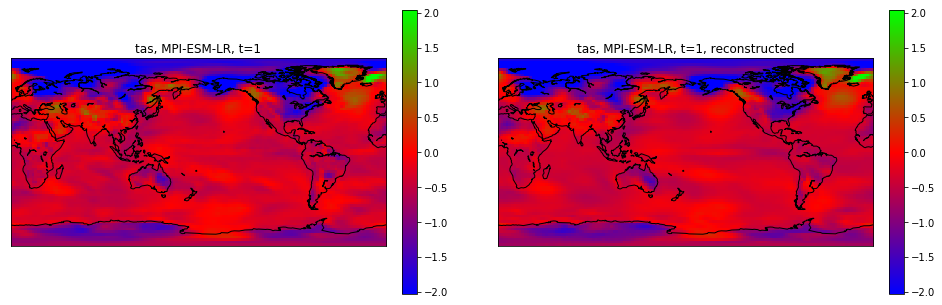

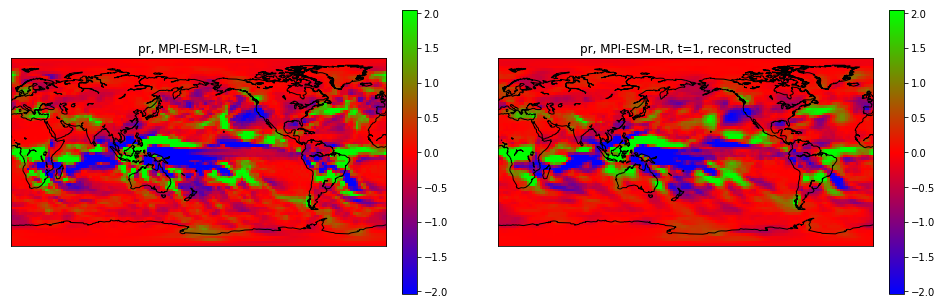

In [12]:
plot_var_spatial(X_valid[:,:,:,:1], X_inv_tas.reshape((N_valid, N_lat, N_lon, 1)), name='tas, MPI-ESM-LR', t=1)
plot_var_spatial(X_valid[:,:,:,1:], X_inv_pr.reshape((N_valid, N_lat, N_lon, 1)), name='pr, MPI-ESM-LR', t=1)

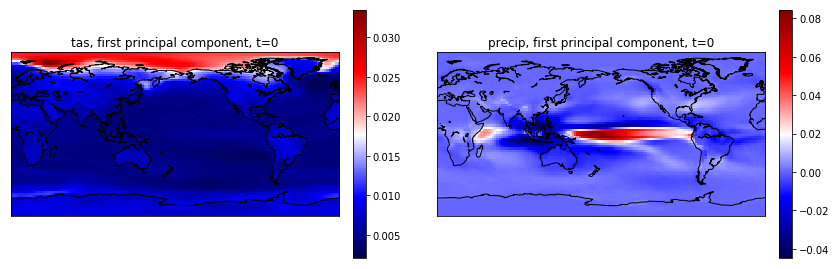

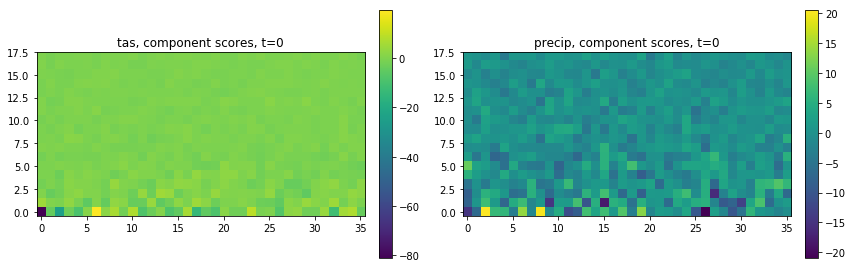

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plot_image_map(pca_tas.components_[0].reshape((72, 144)))
plt.title('tas, first principal component, t=0')
plt.subplot(1,2,2)
plot_image_map(pca_pr.components_[0].reshape((72, 144)))
plt.title('precip, first principal component, t=0')
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(X_vl_tas_pca[0].reshape((18, 36)), origin='lower')
plt.colorbar(fraction=0.035, pad=0.04)
plt.title('tas, component scores, t=0')
plt.subplot(1,2,2)
plt.imshow(X_vl_pr_pca[0].reshape((18, 36)), origin='lower')
plt.colorbar(fraction=0.035, pad=0.04)
plt.title('precip, component scores, t=0')
plt.show()

### Sparse PCA, individual variables

In [18]:
from sklearn.decomposition import SparsePCA

spca_tas = SparsePCA(n_components=9*18, normalize_components=True, max_iter=10, verbose=True)
X_sparse = spca_tas.fit_transform(X_vl_tas_pca)

[dict_learning] ..........

ValueError: cannot reshape array of size 648 into shape (9,18)

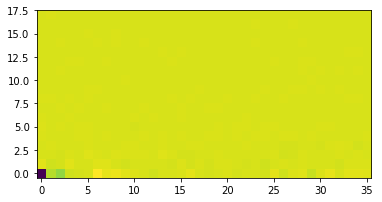

In [19]:
plt.imshow(spca_tas.components_[0].reshape((18,36)), origin='lower')

In [ ]:
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
best_tc = (float('inf'), 0)
best_mse = (float('inf'), 0)
for alpha in alphas:
    print('running sparse PCA for alpha={}'.format(alpha))
    spca_tas = SparsePCA(n_components=target_dims, alpha=alpha, n_jobs=-1)
    spca_tas = spca_tas.fit(X_tr_tas)
    spca_pr = SparsePCA(n_components=target_dims, alpha=alpha, n_jobs=-1)
    spca_pr = spca_pr.fit(X_tr_pr)
    X_vl_tas_spca = spca_tas.transform(X_vl_tas)
    X_sinv_tas = spca_tas.inverse_transform(X_vl_tas_spca)
    spca_tas_mse = mean_squared_error(X_vl_tas, X_sinv_tas)
    X_vl_pr_spca = spca_pr.transform(X_vl_pr)
    X_sinv_pr = spca_pr.inverse_transform(X_vl_pr_spca)
    spca_pr_mse = mean_squared_error(X_vl_pr, X_sinv_pr)
    tc_spca_tas = trust_cont_score(X_vl_tas, X_sinv_tas)
    tc_spca_pr = trust_cont_score(X_vl_pr, X_sinv_pr)
    print('tas/pr mse: {}/{}, tc: {}/{}'.format(spca_tas_mse, spca_pr_mse, tc_spca_tas, tc_spca_pr))
    avg_mse = 0.5*(spca_tas_mse + spca_pr_mse)
    avg_tc = 0.5*(tc_spca_tas + tc_spca_pr)
    if avg_mse < best_mse[0]:
        best_mse = (avg_mse, alpha)
    if avg_tc < best_tc[0]:
        best_tc = (avg_tc, alpha)
        
print(best_mse)
print(best_tc)

### Dense autoencoder, MSE loss

In [8]:
BATCH_SIZE = 4*144

In [9]:
opt_latent_dims = 18*36
opt_l2_reg = 0.0002
inter_dims = opt_latent_dims*2
dae, dae_encoder, dae_decoder = build_dense_autoencoder((N_lat, N_lon, N_vars),
                                                        opt_latent_dims,
                                                        alpha=0.0,
                                                        regularizer=l2(opt_l2_reg))
callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5), PlotLossesCallback()]
dae.load_weights('./data/dense_mse_final_weights.model')

Instructions for updating:
Colocations handled automatically by placer.


/home/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
/home/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


In [ ]:
dae_hist = dae.fit(X_train, X_train, validation_data=(X_valid, X_valid), \
                   batch_size=BATCH_SIZE, epochs=100, shuffle=True, callbacks=callbacks)
dae.save_weights('./data/dense_mse_final_weights.model')

### Dense autoencoder, with augmented loss

In [12]:
opt_latent_dims = 18*36
opt_l2_reg = 0.0002
inter_dims = opt_latent_dims*2
dae_amse, dae_amse_encoder, dae_amse_decoder = build_dense_autoencoder((N_lat, N_lon, N_vars),
                                                                        opt_latent_dims,
                                                                        alpha=0.001,
                                                                        regularizer=l2(opt_l2_reg))
dae.load_weights('./data/dense_amse_final_weights.model')

/home/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
/home/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


In [ ]:
callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5), PlotLossesCallback()]
dae_amse_hist = dae_amse.fit(X_train, X_train, validation_data=(X_valid, X_valid),
                             batch_size=BATCH_SIZE, epochs=100, shuffle=True, callbacks=callbacks)
dae_amse.save_weights('./data/dense_amse_final_weights.model')

### Convolutional autoencoder

In [9]:
opt_n_filters = 16
opt_n_downsamples = 2
opt_l2_reg = 1.0E-4
conv_model, conv_encoder, conv_decoder, conv_latent_dims = \
    build_conv_autoencoder(n_filters=opt_n_filters, n_downsamples=opt_n_downsamples, regularizer=l2(opt_l2_reg))
conv_model.load_weights('./data/conv_final_weights.model')

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5, restore_best_weights=True), PlotLossesCallback()]
conv_hist = conv_model.fit(X_train, X_train, batch_size=2*180, epochs=100, shuffle=True, validation_data=(X_valid, X_valid), callbacks=callbacks)
conv_model.save_weights('./data/conv_final_weights.model')

### Convolutional variational autoencoder

In [9]:
opt_n_filters = 16
opt_n_downsamples = 2
#opt_beta = 0.3
opt_l2_reg = 2.0E-4
vae_model, vae_encoder, vae_decoder, vae_latent_dims = \
    build_conv_vae(n_filters=opt_n_filters, regularizer=l2(opt_l2_reg))
vae_model.load_weights('./data/vae_final_weights.model')

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
callbacks = [EarlyStopping(min_delta=1.0E-3, patience=5, restore_best_weights=True), PlotLossesCallback()]
vae_model.fit(X_train, X_train, batch_size=2*180, epochs=100, shuffle=True, \
              validation_data=(X_valid, X_valid), callbacks=callbacks)
vae_model.save_weights('./data/vae_final_weights.model')

## Visualizations and analysis

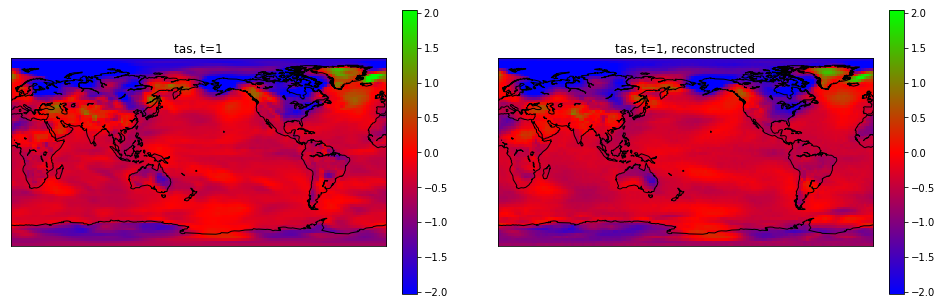

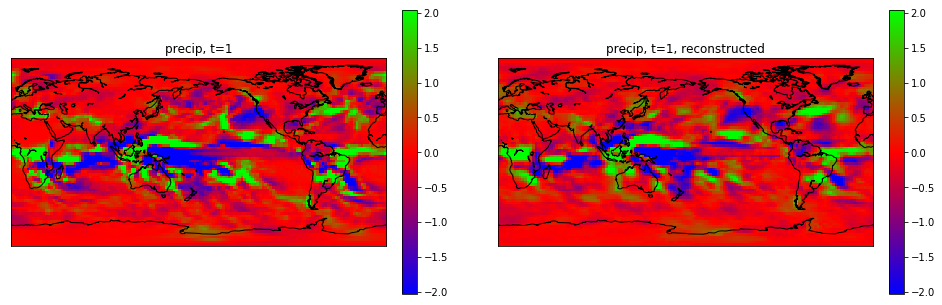

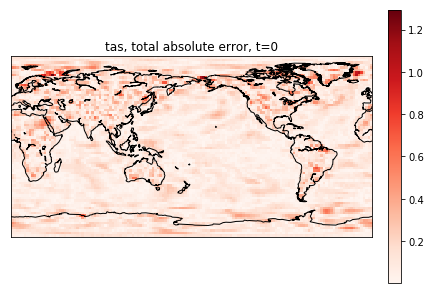

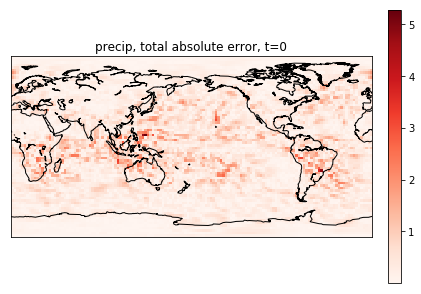

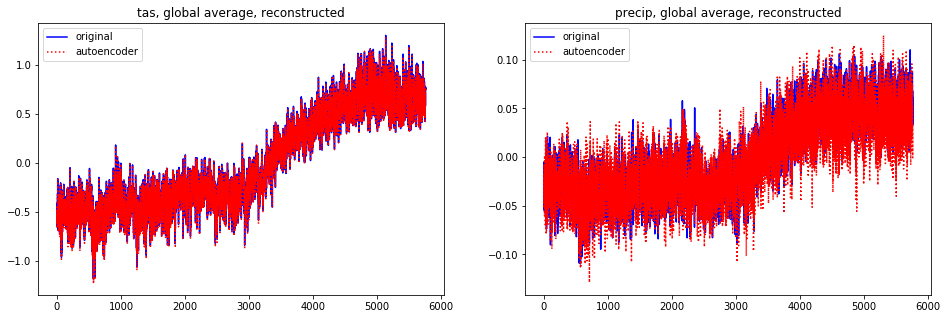

In [12]:
X_pred = dae.predict(X_valid)
plot_var_spatial(X_valid, X_pred, name="tas", c=0, t=1, cmap='brg')
plot_var_spatial(X_valid, X_pred, name="precip", c=1, t=1, cmap='brg')
plt.show()
plot_err_spatial(X_valid, X_pred, name="tas", c=0)
plot_err_spatial(X_valid, X_pred, name="precip", c=1 )
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plot_var_time(X_valid, X_pred, c=0, model_name='autoencoder', name='tas')
plt.subplot(1,2,2)
plot_var_time(X_valid, X_pred, c=1, model_name='autoencoder', name='precip')

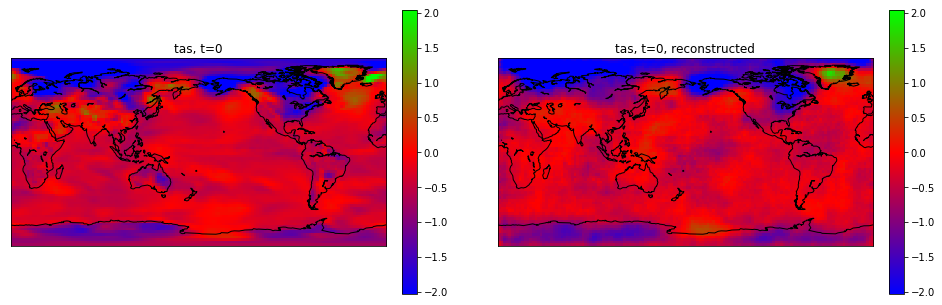

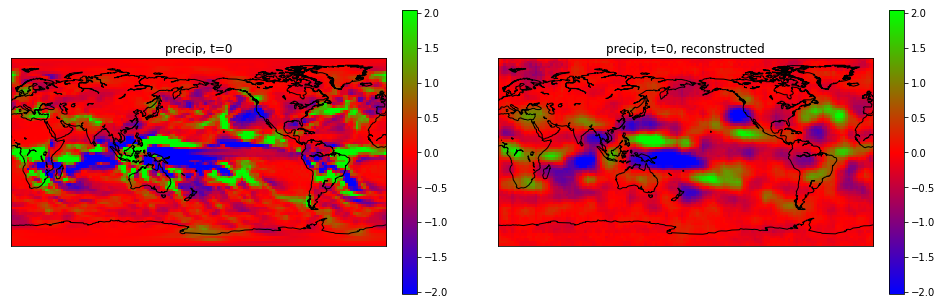

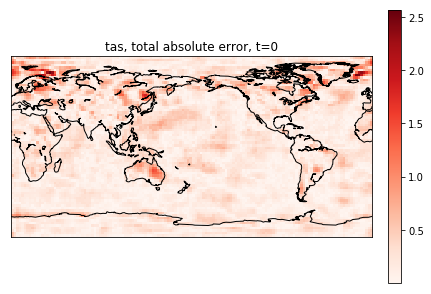

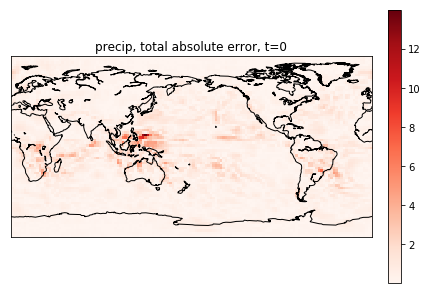

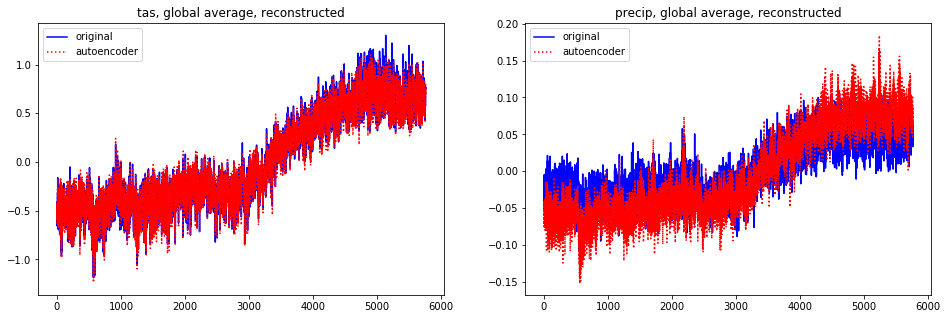

In [11]:
X_pred = conv_model.predict(X_valid)
plot_var_spatial(X_valid, X_pred, name="tas", c=0, t=0, cmap='brg')
plot_var_spatial(X_valid, X_pred, name="precip", c=1, t=0, cmap='brg')
plt.show()
plot_err_spatial(X_valid, X_pred, name="tas", c=0)
plot_err_spatial(X_valid, X_pred, name="precip", c=1 )
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plot_var_time(X_valid, X_pred, c=0, model_name='autoencoder', name='tas')
plt.subplot(1,2,2)
plot_var_time(X_valid, X_pred, c=1, model_name='autoencoder', name='precip')

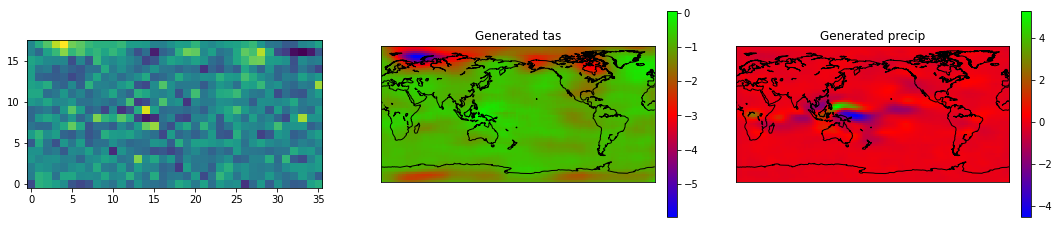

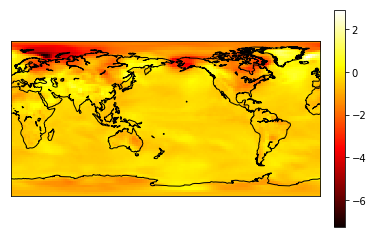

In [15]:
z_means, z_sigmas = vae_encoder.predict(X_valid)
rand_seed = np.random.normal(size=(N_time*2, 18*36*2), loc=0.5, scale=0.5)
z = z_means + np.exp(z_sigmas)*rand_seed
X_generated = vae_decoder.predict(z)

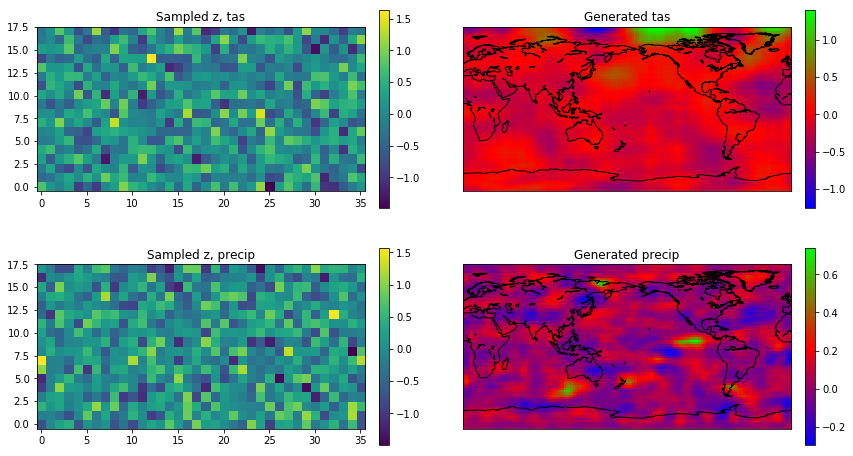

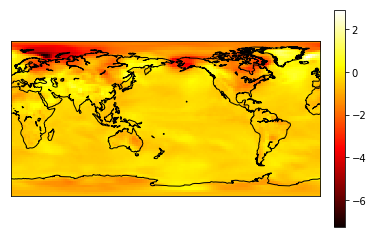

In [46]:
z = np.random.normal(size=(N_time*2, 18*36*2), loc=0, scale=0.5)
X_generated = vae_decoder.predict(z)
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.imshow(z[0].reshape((18,36,2))[:,:,0], origin='lower')
plt.title('Sampled z, tas')
plt.colorbar(fraction=0.035, pad=0.04)
plt.subplot(2,2,2)
plot_image_map(X_generated[0,:,:,0], cmap='brg', title='Generated tas')
plt.subplot(2,2,3)
plt.imshow(z[0].reshape((18,36,2))[:,:,1], origin='lower')
plt.colorbar(fraction=0.035, pad=0.04)
plt.title('Sampled z, precip')
plt.subplot(2,2,4)
plot_image_map(X_generated[0,:,:,1], cmap='brg', title='Generated precip')
plt.show()
plot_image_map(X_valid[0,:,:,0], cmap='hot')
plt.show()

In [51]:
mu_0, log_sigma_0 = vae_encoder.predict(X_valid[range(0,N_valid,2)])
mu_1, log_sigma_1 = vae_encoder.predict(X_valid[range(1,N_valid,2)])
mu_avg_0 = np.mean(mu_0.reshape((N_time, 18, 36, N_vars)), axis=(1,2))
mu_avg_1 = np.mean(mu_1.reshape((N_time, 18, 36, N_vars)), axis=(1,2))
sigma_avg_0 = np.mean(np.exp(log_sigma_0.reshape((N_time, 18, 36, N_vars))), axis=(1,2)).squeeze()
sigma_avg_1 = np.mean(np.exp(log_sigma_1.reshape((N_time, 18, 36, N_vars))), axis=(1,2)).squeeze()

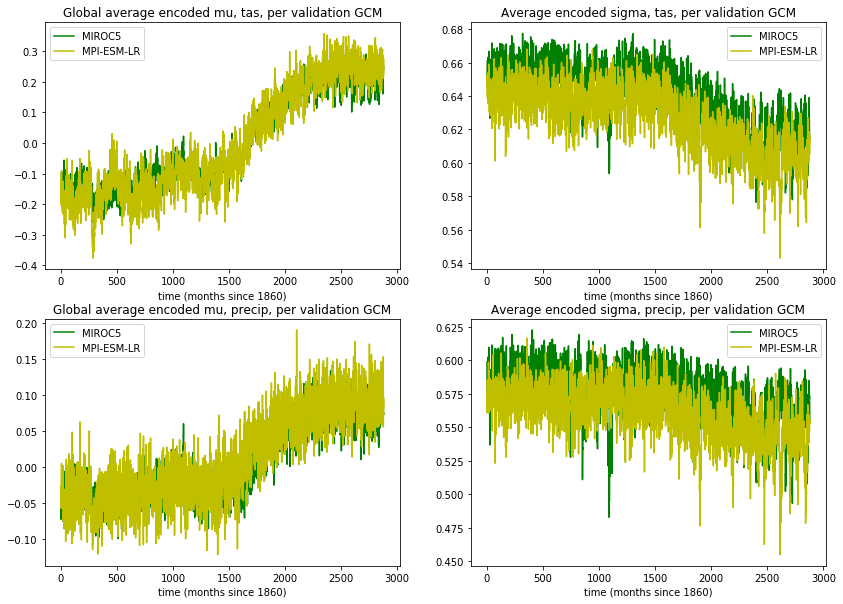

In [62]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(range(N_time), -mu_avg_0[:,0], c='g')
plt.plot(range(N_time), -mu_avg_1[:,0], c='y')
plt.legend(['MIROC5', 'MPI-ESM-LR'])
plt.title('Global average encoded mu, tas, per validation GCM')
plt.xlabel('time (months since 1860)')
plt.subplot(2,2,2)
plt.plot(range(N_time), sigma_avg_0[:,0], c='g')
plt.plot(range(N_time), sigma_avg_1[:,0], c='y')
plt.legend(['MIROC5', 'MPI-ESM-LR'])
plt.title('Average encoded sigma, tas, per validation GCM')
plt.xlabel('time (months since 1860)')
plt.subplot(2,2,3)
plt.plot(range(N_time), -mu_avg_0[:,1], c='g')
plt.plot(range(N_time), -mu_avg_1[:,1], c='y')
plt.legend(['MIROC5', 'MPI-ESM-LR'])
plt.title('Global average encoded mu, precip, per validation GCM')
plt.xlabel('time (months since 1860)')
plt.subplot(2,2,4)
plt.plot(range(N_time), sigma_avg_0[:,1], c='g')
plt.plot(range(N_time), sigma_avg_1[:,1], c='y')
plt.legend(['MIROC5', 'MPI-ESM-LR'])
plt.title('Average encoded sigma, precip, per validation GCM')
plt.xlabel('time (months since 1860)')
plt.show()

## DCGAN outputs

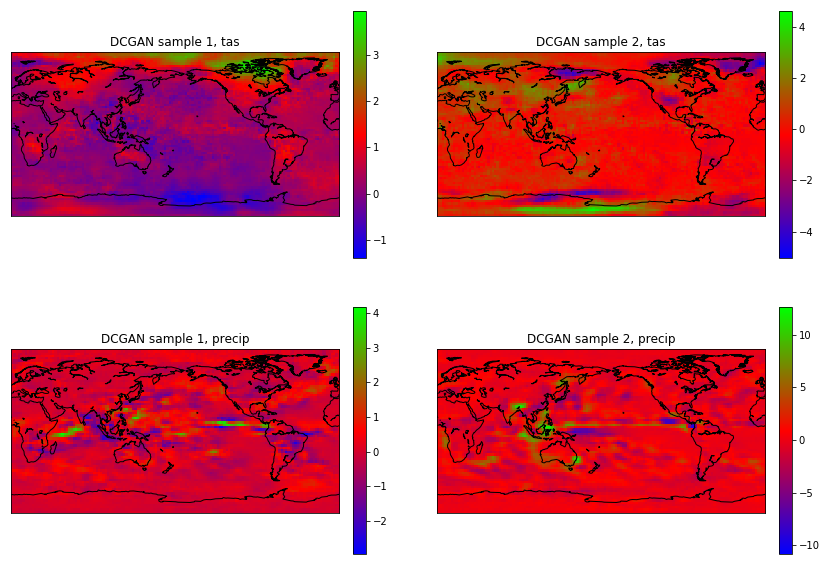

In [6]:
X_dcgan = np.load('./data/dcgan_outputs.npy')
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plot_image_map(X_dcgan[0,:,:,0], cmap='brg')
plt.title('DCGAN sample 1, tas')
plt.subplot(2,2,2)
plot_image_map(X_dcgan[1,:,:,0], cmap='brg')
plt.title('DCGAN sample 2, tas')
plt.subplot(2,2,3)
plot_image_map(X_dcgan[0,:,:,1], cmap='brg')
plt.title('DCGAN sample 1, precip')
plt.subplot(2,2,4)
plot_image_map(X_dcgan[1,:,:,1], cmap='brg')
plt.title('DCGAN sample 2, precip')
plt.show()